# Summary

In this notebook, we intend to build a ETL pipeline to process the raw transaction data. The specific goals are outlined as following:

- Cleanses and validates transaction data
- Performs necessary transformations (currency conversion, timestamp standardization)
- Aggregates data at different time intervals
- Implement data quality checks and validation rules
- Create summary statistics and data profiling reports

Data source:
https://www.kaggle.com/datasets/ealaxi/paysim1/data

Coding environment:
Google colab, Python 3 + CPU



## packages and dependencies

In [1]:
!pip install kaggle

In [2]:
import os

# Create the .kaggle directory
os.makedirs('/root/.config/kaggle', exist_ok=True)

# Move kaggle.json to the .kaggle directory
!mv kaggle.json /root/.config/kaggle/

In [3]:
# security concern on API key
!chmod 600 /root/.config/kaggle/kaggle.json

In [4]:
import numpy as np
import pandas as pd

import kaggle

import zipfile

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## dataset

In [5]:
!kaggle datasets download -d ealaxi/paysim1

Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 98% 175M/178M [00:07<00:00, 27.1MB/s]
100% 178M/178M [00:07<00:00, 24.7MB/s]


In [6]:
with zipfile.ZipFile("paysim1.zip", 'r') as zip_ref:
    # Extract to a folder named "data"
    zip_ref.extractall("data")

In [7]:
# if we work this one on databricks, we may use databricks widgets to make this notebook/whole process reusable easily

df = pd.read_csv("data/PS_20174392719_1491204439457_log.csv")

# Display the first few rows
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


## data understanding & basic preprocessing

### schema

In [8]:
# review the schema
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Shown from our current knowledge, there is no unique identifier for each transaction. This step will be skipped.

### timestamp

In [9]:
# check time stamp
df['step'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

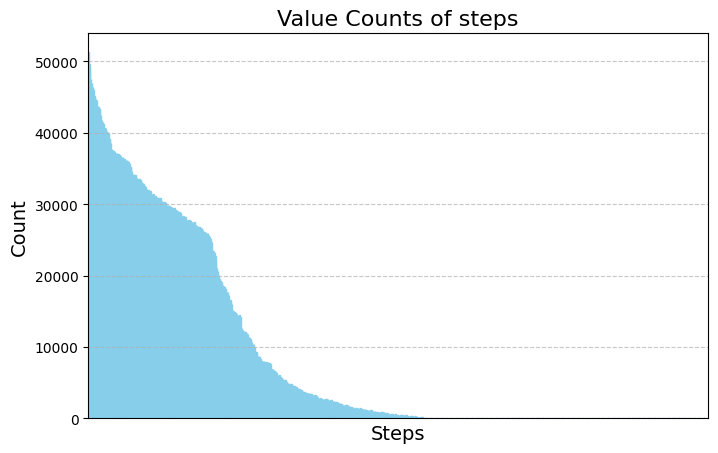

In [10]:
# plot the distribution of time stamp
# Value counts for the column
value_counts = df['step'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
value_counts.plot(kind='bar', color='skyblue', edgecolor='skyblue')
plt.title('Value Counts of steps', fontsize=16)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Set blank xticks to allow quicker plot
plt.xticks([], [])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### null check & data type validate


In [11]:
# identify missing data

print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [12]:
df['type'] = df['type'].astype(str)
df['nameOrig'] = df['nameOrig'].astype(str)
df['nameDest'] = df['nameDest'].astype(str)

In [13]:
print(df['type'].apply(type).value_counts())
print(df['nameOrig'].apply(type).value_counts())
print(df['nameDest'].apply(type).value_counts())

type
<class 'str'>    6362620
Name: count, dtype: int64
nameOrig
<class 'str'>    6362620
Name: count, dtype: int64
nameDest
<class 'str'>    6362620
Name: count, dtype: int64


### duplicates check

In [14]:
print(df.duplicated().sum())

0


### standardize

In [15]:
# delete minus transaction
df = df[df['amount'] > 0]

In [16]:
# check type: no need to standard the case here
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

### transaction preview

In [17]:
max(df['amount'])

92445516.64

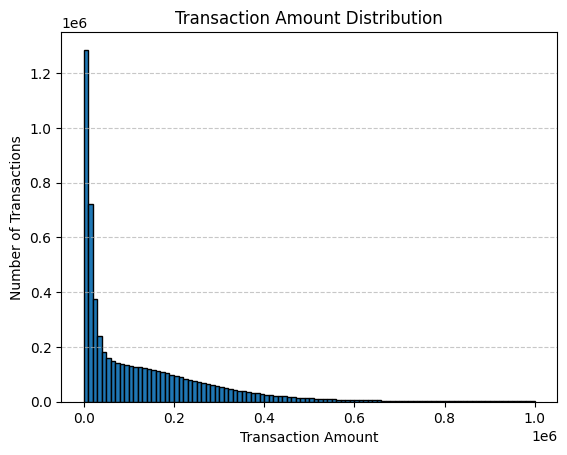

In [18]:

# Plot the histogram
plt.hist(df['amount'], bins=list(range(0, 1000001, 10000)), edgecolor='black')  # Adjust `bins` as needed
plt.xlabel('Transaction Amount')
plt.ylabel('Number of Transactions')
plt.title('Transaction Amount Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## aggregation pre-processing

For data with datetime type index, we could use df.resample() function to do time-series analysis. Here, we separate the data based on the step column and use df.groupby() function to do aggregate analysis.

In [19]:
df['day'] = (df['step'] - 1) // 24
df['week'] = df['day'] // 7
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,week
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0


## summary statistics and data profiling reports



### general profiling

In [20]:
# data types & schema
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6362604 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
 11  day             int64  
 12  week            int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 679.6+ MB


In [21]:
# missing data
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
day               0
week              0
dtype: int64


In [22]:
# distribution

# Set the display format to avoid scientific notation
pd.set_option('display.float_format', '{:,.2f}'.format)

df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,week
count,"6,362,604.00","6,362,604.00","6,362,604.00","6,362,604.00","6,362,604.00","6,362,604.00","6,362,604.00","6,362,604.00","6,362,604.00","6,362,604.00"
mean,243.40,"179,862.36","833,885.20","855,115.82","1,100,702.16","1,224,997.20",0.00,0.00,9.49,1.00
std,142.33,"603,858.92","2,888,246.00","2,924,051.87","3,399,182.94","3,674,132.20",0.04,0.00,5.92,0.86
min,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,"13,389.75",0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00
50%,239.00,"74,872.88","14,208.58",0.00,"132,705.84","214,661.65",0.00,0.00,9.00,1.00
75%,335.00,"208,721.82","107,316.00","144,258.52","943,036.71","1,111,909.52",0.00,0.00,13.00,1.00
max,743.00,"92,445,516.64","59,585,040.37","49,585,040.37","356,015,889.35","356,179,278.92",1.00,1.00,30.00,4.00


According to the summary above, outliers happen mostly in balance/amount-related columns. There are vast amounts of money as outliers.

Confusion Matrix:
[[6354407       0]
 [   8181      16]]


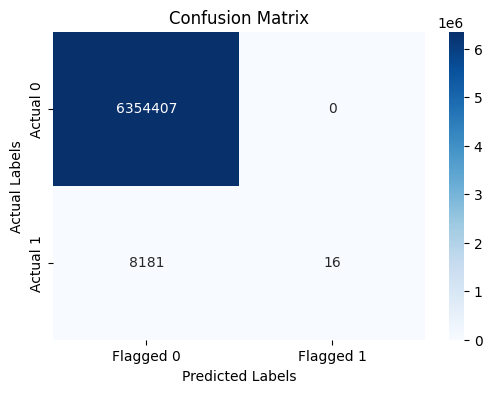

In [23]:
# confusion matrix of isFraud and isFlaggedFraud
# it helps us understand the flag system's performance

# Generate confusion matrix
cm = confusion_matrix(df['isFraud'], df['isFlaggedFraud'])

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Flagged 0', 'Flagged 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

### time interval based statistics


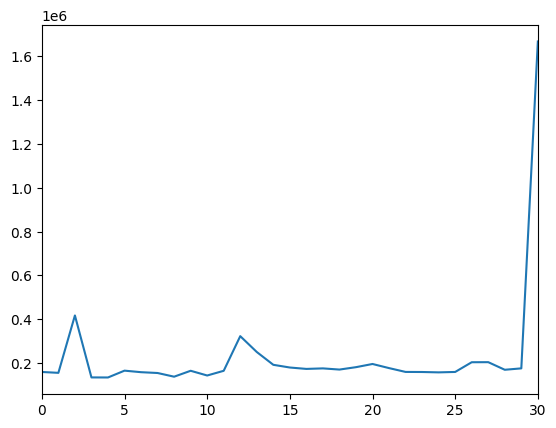

In [24]:
# plot daily average amount
daily_average = df.groupby('day')['amount'].mean()
x = range(31)

# Create the plot
plt.plot(x, daily_average)

# Set the x-axis range from 0 to 30
plt.xlim(0, 30)
plt.show()

We may see from the above plot that a lot of abnormal transaction happened on the last day, which requires our attention. and the 2 and 12 day also requires attention.

We can do a few similar analyses on other columns for further study.

For weekly data, as we only have 5 weeks (0-4 indexed) on records, it's feasible to have a numerical description for analysis.

In [25]:
cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest']
df.groupby("week")[cols].describe()

amount                                                            \
            count       mean        std  min       25%       50%        75%   
week                                                                          
0    1,930,180.00 160,323.93 266,919.80 0.06 13,049.50 77,864.54 215,805.31   
1    2,854,592.00 192,782.82 809,928.83 0.01 13,043.51 73,327.99 204,182.46   
2    1,279,258.00 182,682.67 438,823.28 0.03 15,142.20 75,310.83 210,198.46   
3      232,129.00 168,538.69 436,830.92 0.26 11,402.43 68,795.35 199,962.50   
4       66,445.00 177,614.92 522,208.81 0.36 13,464.88 74,678.58 207,442.83   

                   oldbalanceOrg             ... oldbalanceDest  \
               max         count       mean  ...            75%   
week                                         ...                  
0    10,000,000.00  1,930,180.00 855,773.88  ...     945,658.22   
1    92,445,516.64  2,854,592.00 830,641.59  ...     940,580.53   
2    19,953,778.06  1,279,258.00 847,428.85  ...     960,460.94   
3    15,415,938.31    232,129.00 688,025.28  ...     886,082.60   
4    15,116,218.46     66,445.00 586,200.53  ...     824,138.00   

                    newbalanceDest                                      \
                max          count         mean          std  min  25%   
week                                                                     
0     42,207,404.59   1,930,180.00 1,113,361.63 2,399,685.10 0.00 0.00   
1    355,553,416.30   2,854,592.00 1,235,454.93 3,933,771.70 0.00 0.00   
2    356,015,889.35   1,279,258.00 1,361,094.29 4,449,148.10 0.00 0.00   
3    328,194,464.92     232,129.00 1,271,900.63 4,239,453.61 0.00 0.00   
4    172,319,019.71      66,445.00 1,234,528.21 3,991,334.77 0.00 0.00   

                                             
            50%          75%            max  
week                                         
0    226,546.74 1,148,935.17  42,283,775.08  
1    212,418.71 1,091,515.05 355,553,416.30  
2    214,281.10 1,122,808.71 356,179,278.92  
3    170,453.40 1,020,071.11 328,431,698.23  
4    176,377.29   974,360.33 172,321,214.32  

[5 rows x 40 columns]